<a href="https://colab.research.google.com/github/nina-mizrahi/computational-neuroscience-projects-and-labs/blob/main/Comp_Neuro_Final_Project_%3C3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nina Mizrahi

Ella Zhu

Computational Neuroscience Final Project <3


#Part One: Obtaining and Cleaning up Data



This code processes neural data from .mat and .lfp files by defining three functions. These functions manage different data sources for neural analysis, dealing with spikes, maze navigation, and LFPs:

- **compAnly function:** extracts and structures info related to maze trial data, decimates the data, & filters the values to construct required columns for lapID.

- **get_spikes function:** retrieves spike data from a mat_file, and considering sampling rate, bins it by time and cluster.

- **get_LFP funtion:** extracts and downsamples LFP data from lfp_file, accounting for the number of channels and sampling rate.


In [ ]:
from scipy.signal import decimate
import numpy as np
import math
import os
from scipy import io
import matplotlib.pyplot as plt

def compAnly(Track, fs):
    """
    Input:
    Track = Contains information on the session pertaining to the track
    fs = sampling frequency

    Output:
    lapID = Data stored in the format listed below

    lapID format:
    Column 0: Trial Number
    Column 1: Maze arm (1/2/3)
    Column 2: Correct (0/1)
    Column 3: other/first approach/port/last departure (0/1/2/3)
    Column 4: position in mm
    """

    dec = int(1250//fs) #decimation factor

    lapID = np.array([ np.squeeze(Track["lapID"][0][0])[::dec] ])
    lapID = np.append(lapID, [ np.squeeze(Track["mazeSect"][0][0])[::dec] ], axis = 0)
    lapID = np.append(lapID, [ np.squeeze(Track["corrChoice"][0][0])[::dec] ], axis = 0)
    lapID = np.append(lapID, np.zeros((1, len(lapID[0]))), axis = 0)
    lapID = np.append(lapID, decimate(Track["xMM"][0][0].T,dec), axis =0)
    lapID = lapID.T

    # Filter values and construct column 3
    lapID[np.in1d(lapID[:,1], np.array(range(4, 10)), invert = True), 1] = 0
    lapID[lapID[:, 1] > 6, 3] = 2
    lapID[lapID[:, 1] > 0, 1] = (lapID[lapID[:,1] > 0, 1] - 1) % 3 + 1
    lapID[lapID[:, 1] == 0, :] = 0

    # Identify samples corresponding to the first period when the animal enters the maze section
    for i in range(1, int(np.max(lapID[:, 0]) + 1)):
        r = np.logical_and(lapID[:, 0] == i, lapID[:, 3] == 2)
        inds = np.where(lapID[:, 0] == i)[0]
        lapID[inds[inds < np.where(r > 0)[0][0]], 3] = 1
        lapID[inds[inds > np.where(r > 0)[0][-1]], 3] = 3

    # Return structured data
    return lapID

def get_spikes(mat_File,fs):
    """
    Input:
    mat_file = metadata file of type .mat
    fs = sampling rate

    Output:
    sp = binned spikes
    """
    mat = io.loadmat(mat_file, variable_names = ['Spike', 'Clu','xml'])
    n_channels = mat['xml']['nChannels'][0][0][0][0]
    dec = 1250//fs
    max_spike_res = np.ceil(np.max(mat['Spike']['res'][0][0])/dec) + 1
    max_spike_clu = np.max(mat['Spike']['totclu'][0][0]) + 1# Precompute the bins
    bins_res = np.arange(max_spike_res)
    bins_clu = np.arange(max_spike_clu)
    spike_res = np.squeeze(mat['Spike']['res'][0][0]) // dec
    spike_clu = np.squeeze(mat['Spike']['totclu'][0][0]) - 1

    # Bin both dimensions using histogram2d.
    sp, _,_ = np.histogram2d(spike_res, spike_clu, bins = (bins_res, bins_clu) )
    sp = sp.astype(np.uint8)

    mask = mat['Clu']['shank'][0][0][0] <= math.ceil(n_channels / 8)
    sp = sp[:, mask]

    return sp

def get_LFP(lfp_file, n_channels, fs):
    """
    Input:
    lfp_file = raw lfp data file of type .lfp
    fs = sampling rate

    Output:
    X = formatted lfp data
    """

    dec = int(1250//fs)
    file_size = os.path.getsize(lfp_file)
    data_size = np.dtype('int16').itemsize
    total_elements = file_size // data_size
    n_samples = total_elements // n_channels

    # Clip the dimensions to ensure the appropriate number of electrodes. Use multiple [0]'s to access the desired data.
    if n_channels > 256:
        n_keep = 255
    else:
        n_keep = 64 #1 64 electrodes in one array, one of the three arrays worth of data

    # Efficiently load and decimate the data
    #slice_data = np.memmap(lfp_file, dtype='int16', mode='r', shape=(n_samples, n_channels))
    #X = decimate(slice_data[:, :n_keep], dec, axis=0)
    final_length = math.ceil(n_samples / dec)
    X = np.zeros((final_length, n_keep), dtype=np.float32)

    # Process each channel individually and store in the pre-allocated array
    for channel in range(n_keep):
        # Load the channel data using memmap
        channel_data = np.memmap(lfp_file, dtype='int16', mode='r', shape=(n_samples, n_channels))[:, channel]
        # Decimate the channel data
        X[:, channel] = decimate(channel_data, dec, axis=0)
        print(channel)

    return X

The following code loads data from a MATLAB file (rec01_BehavElectrDataLFP.mat) using the io.loadmat function from SciPy. It extracts the 'Track' variable from this .mat file and then calls the compAnly function with this track data and a specified sampling rate (fs) to process behavioral information (lapID).

In [ ]:
from scipy import io

fs = 1250/8 #sampling rate in Hz

#Mounts Google Drive to access files.
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/"

# Specify data files
mat_file = data_dir + "rec01_BehavElectrDataLFP.mat" #contains spiking and behavioral data
lfp_file = data_dir + "rec01.lfp" #contains LFP data

# Extract behavior
mat = io.loadmat(mat_file, variable_names = ['Track'])#, 'Spike', 'Clu'])
lapID = compAnly(mat['Track'],fs)

Mounted at /content/drive


Here we create a plot for a specific trial (trNum 1 in this case) based on the processed lapID data from the compAnly function. It plots the position data (lapID[inds,4]) against the sample indices (inds) for different events within the trial, such as the first approach, reward, and last departure. The sampling rate of 1250/8 was chosen to get from 1250hz to around around 167 hz, which is a more effective sampling rate for gamma rythms.

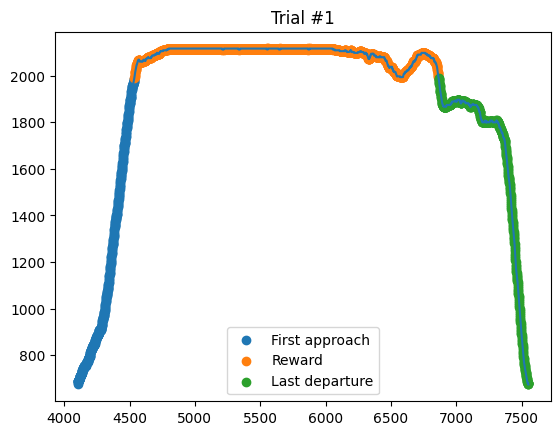

In [ ]:
trNum = 1 # Defining trial number of interest, for our purposes we will only look at 1

# Find indices where lapID's first column matches the trial number
inds = np.where(lapID[:,0] == trNum)[0]

# Plot the position against indices for the specified trial
plt.plot(inds,lapID[inds,4]);

# Define labels for different events in the trial
lab = ['First approach','Reward','Last departure']

# Iterate through different events, identify their indices, and plot them
for i in range(1,4):
    inds = np.where(np.logical_and(lapID[:,0] == trNum, lapID[:,3] == i))[0]
    plt.scatter(inds,lapID[inds,4],label=lab[i-1]);

plt.legend();
plt.title('Trial #' + str(trNum));


 This code loads data from the MATLAB file (rec01_BehavElectrDataLFP.mat) and extracts the number of channels (n_channels) from the 'xml' variable. Then, it calls the get_LFP function to process LFP data from the the rec01.lfp file using the extracted number of channels and the provided sampling rate (fs).  Finally, it prints the shape of the processed LFP data array (X.shape) so we know how many channels we are working with.

In [ ]:
# Load metadata 'xml' from mat_file
mat = io.loadmat(mat_file, variable_names = ['xml'])

# Extract the number of channels from MATLAB file
n_channels = mat['xml']['nChannels'][0][0][0][0]

#getting LFP data using 'get_LFP' function and store it in variable'X'
X = get_LFP(lfp_file,n_channels,fs)

X.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


(618875, 64)

X has a shape of (618875, 64). The 618,875 rows hold timestamps, and each column contains data from 64 different channels/electrodes.

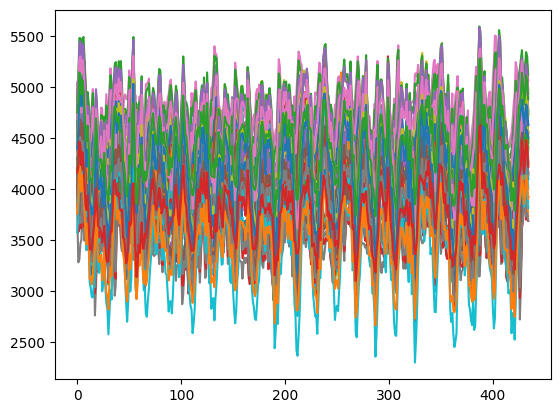

In [ ]:
plt.plot(X[np.logical_and(lapID[:,0]==1,lapID[:,3]==1)])
#lapID[:,0]==1 means we are only looking at the first trial
#lapID[:,3]==1 means that we're only taking parts of data where the rat is running towards reward


This code creates a plot showing the spikes in the LFP data for a specific trial (trNum = 1). The plot indicates the points where spikes occur in the LFP data (X[inds, 0]) for different events within the trial, such as the first approach, reward, and last departure.

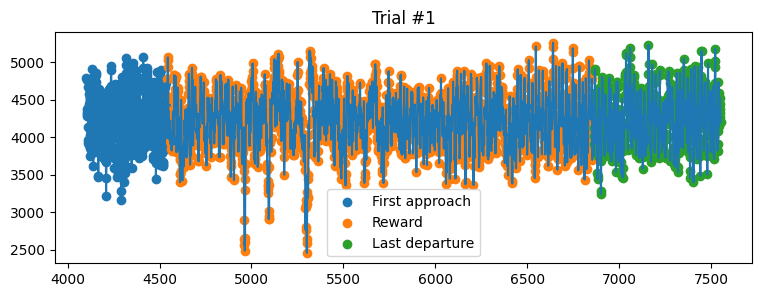

In [ ]:
# Retrieving binned spikes using the 'get_spikes' function
sp = get_spikes(mat_file,fs)
trNum = 1 #trial number of interest

# Create a figure for plotting
fig,_=plt.subplots(1,1,figsize=(9,3))

# Find indices where lapID's first column matches the trial number
inds = np.where(lapID[:,0] == trNum)[0]

# Plot the first channel of LFP data against indices for the specified trial
plt.plot(inds,X[inds,0]);

# Iterate through different events, identify their indices, and scatter plot them
lab = ['First approach','Reward','Last departure']
for i in range(1,4):
    inds = np.where(np.logical_and(lapID[:,0] == trNum, lapID[:,3] == i))[0] #indices for the specified trial and event type
    plt.scatter(inds,X[inds,0],label=lab[i-1]);
plt.legend();
plt.title('Trial #' + str(trNum));

#Part Two: Identifying Theta and Gamma Signals From Data

The first step of this process is to run PCA on the data to find the main component in the multi-channel data to produce a single signal for us to analyze. This process reduces the dimensionality of the LFP data, capturing the most important variation across channels into a single principal component (PC1).


In [ ]:
from sklearn.decomposition import PCA

#Step 1: Mean centering
X_mean_centered = X - X.mean(axis=0)

# Instantiate PCA with the desired number of components
pca = PCA(n_components=1)

# Fit PCA on your multi-channel data
pca.fit(X_mean_centered)

# Get the first principal component (PC1)
first_principal_component = pca.components_[0]

# Optionally, you can transform your data into the PCA space
X_pca = pca.transform(X_mean_centered)

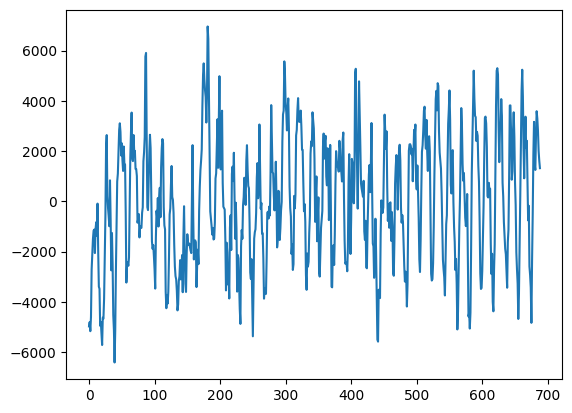

In [ ]:
plt.plot(X_pca[inds]) #single signal for us to analyze!

The shape (689, 1) indicates that the data consists of 689 samples along the first principal component obtained from PCA. The number 1 in the tuple represents the single feature or dimension in this transformed space.

In [ ]:
print(X_pca[inds].shape)

(689, 1)


This code calculates a Continuous Wavelet Transform (CWT) on PCA-transformed LFP data (X_pca). We use a Complex Morlet wavelet to analyze the data across different frequency scales. Specifically, we choose scipy.signal.morlet2 because it is designed to work with cwt. The cwt_result contains the result of the CWT, representing the frequency content at different scales across the dataset.
After computing the transform, it plots the real and imaginary parts of the resulting wavelet coefficients to visualize how frequencies in the data change over time. This helps us understand the frequency content and patterns present in the transformed data.


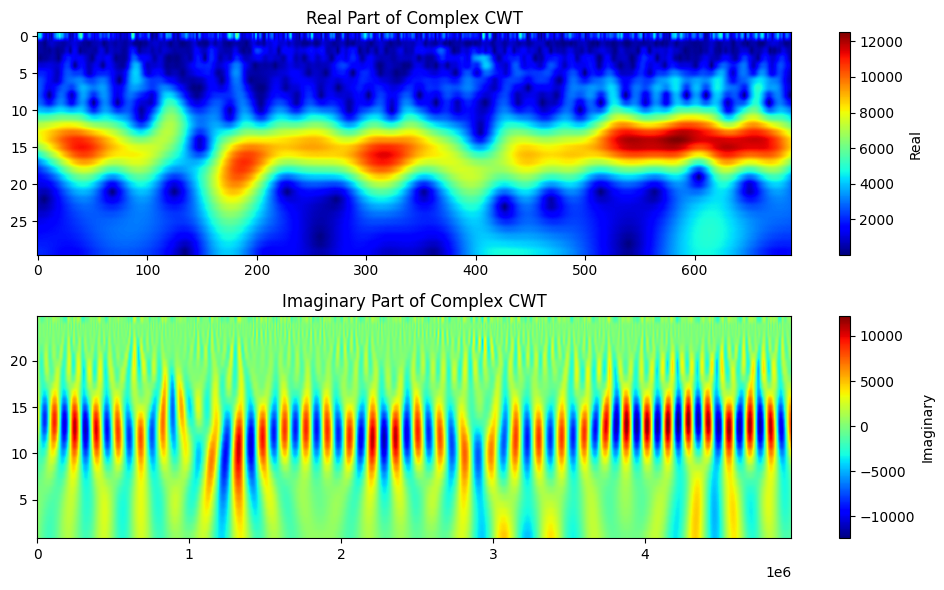

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cwt, morlet2

# Define the sampling rate
sampling_rate = 1250 / 8

# Define the desired frequency range for the CWT
min_freq = 2 # Minimum frequency in Hz
max_freq = (sampling_rate / 2)  # Nyquist frequency in Hz

# Define the number of scales
num_scales = 100 #range of frequencies is characterized by 100 logarithmically spaced scales from 1 to 30.

# Compute the logarithmically spaced scales (frequencies) within the defined range
scales = np.arange(1,31)

# Create a vector of frequencies corresponding to each scale
frequencies = sampling_rate / (2 * np.pi * scales)

# Compute the CWT using a complex-valued Morlet2 wavelet
cwt_result = cwt(X_pca.squeeze(), morlet2, scales)

plt.figure(figsize=(10, 6))

# Plot the real part of the complex CWT
plt.subplot(2, 1, 1)
plt.imshow(np.abs(cwt_result[:,inds]), aspect='auto', cmap='jet')
plt.colorbar(label='Real')
plt.title('Real Part of Complex CWT')

# Plot the imaginary part of the complex CWT
plt.subplot(2, 1, 2)
plt.imshow(np.imag(cwt_result[:,inds]), extent=[0, np.sum(inds), frequencies[-1], frequencies[0]], aspect='auto', cmap='jet')
plt.colorbar(label='Imaginary')
plt.title('Imaginary Part of Complex CWT')

plt.tight_layout()
plt.show()

We can see from the plot above that the theta rythm shows up as a quite pronouced band in the center of our colorbar. The theta band, which should be in the range of 0-10 is less evident.  

Next, we computed and visualized the average power across the frequencies obtained from the CWT analysis. Calculating the power from the CWT tells you how much signal strength exists at different frequencies. Understanding the power distribution within specific frequency bands, such as theta and gamma, is crucial for identifying frequency-related characteristics within the dataset. This visualization assists in recognizing distinct frequency-related patterns and features present in the data.

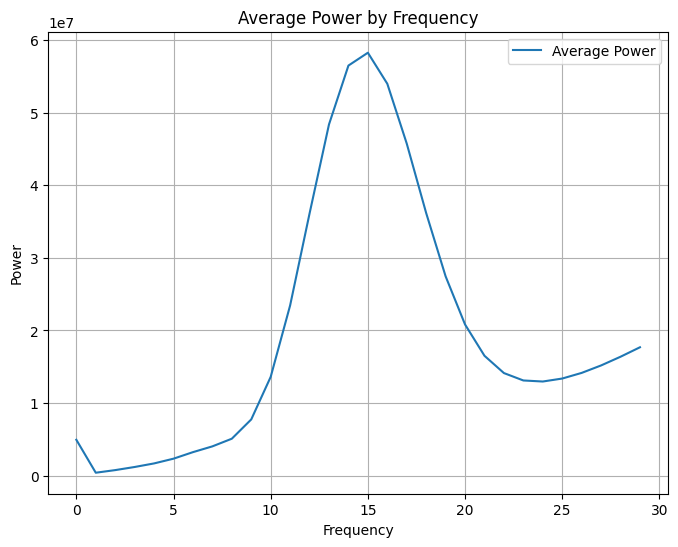

In [ ]:
# Calculate the squared magnitude of the CWT matrix to obtain power values
power = np.abs(cwt_result) ** 2

# Calculate the average power across time for each frequency (or scale)
average_power = np.mean(power, axis=1)

#Derive frequencies corresponding to the scales used in the CWT.
frequencies = sampling_rate / (scales)

# Plot the average power by frequency
plt.figure(figsize=(8, 6))
plt.plot(average_power, label='Average Power')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Average Power by Frequency')
plt.legend()
plt.grid(True)
plt.show()

#using 78.125 for theta
# using 31.25 for gamma

The plot above depicting average power across frequencies indicates a significant spike in power at frequency 15, corresponding to our robust theta rhythm. However, the distinct dip around frequency 2-3, typically associated with the gamma rhythm, lacks the expected clarity. To further delineate the gamma frequency range, we will use a comodulogram to supplement our definition of the gamma frequency band.





The following code block includes our calculation to visualize the comodulogram which reflects the modulation between the phase of specific frequency bands ( from the CWT) and the amplitude of others. This code uses the Hilbert transform and z-scoring to obtain amplitudes and then computes the comodulogram by taking the absolute value of the dot product between the phase and amplitude components.
- The Z-score normalization helps in standardizing the amplitude values across the frequencies from cwt_result. This process ensures that the amplitudes have a mean of zero and a standard deviation of one, which is useful for comparing different frequency bands.
- The Hilbert transform is used to derive the analytic signal, extracting the varying strength or magnitude of a signal over time from the z-scored CWT data. It's a common method to obtain instantaneous amplitudes in time or frequency domains.

The resulting log-transformed comodulogram is then visualized.

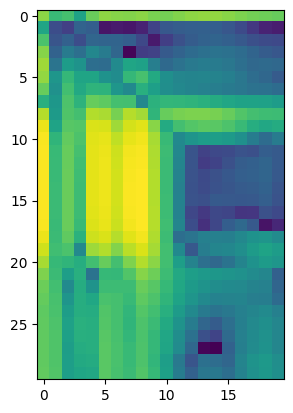

In [ ]:
from scipy.signal import hilbert
from scipy.stats import zscore

# Filtering indices based on condition that rat is running
inds = lapID[:,3] == 1

# Calculating the absolute values of the CWT result
amps = np.abs(cwt_result)

# Applying z-score normalization along the rows (across frequencies)
amps = zscore(amps,axis=1)

# Applying the Hilbert transform along the rows (across frequencies)
amps = hilbert(amps,axis=1)

# Selecting a subset of rows (frequencies) and corresponding indices (just so we know what side of the comodulagram is showing amplitude)
amps = np.conj(amps[:20,inds])

# This step calculates the absolute value of the dot product between the exponential of the phase of the CWT result
# and the complex conjugate of the amplitudes obtained previously
comod = np.abs(np.exp(1j*np.angle(cwt_result[:,inds]))@amps.T)

plt.imshow(np.log(comod))

The bright yellow regions in our comodulogram signify areas of strong coupling between specific theta phases and gamma amplitudes. This visual insight reveals that theta phases within the 12-18 range relate distinctly to amplitudes in the gamma range. Considering these findings, we can to refine our definition of the gamma frequency band. Notably, we observe robust coupling around a frequency of 4 within the gamma band, which we'll take as our reference point moving forward.


The following cide block plots the PCA-transformed LFP data alongside specific slices of the CWT result corresponding to gamma (at slice 4) and theta (at slice 15). These slice vales were determined using the average power by frequency plot (which are coroborated by the comodulagram) above.



/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


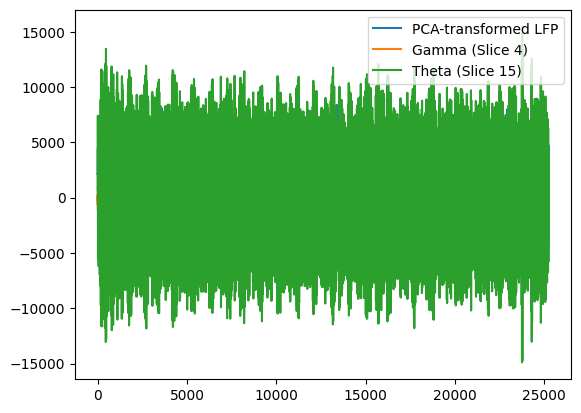

In [ ]:
import matplotlib.pyplot as plt
plt.plot(X_pca[inds], label='PCA-transformed LFP')
plt.plot(cwt_result[3, inds], label='Gamma (Slice 4)')
plt.plot(cwt_result[15, inds], label='Theta (Slice 15)')
plt.legend()
plt.show()

#Part Three: Extracting Theta and Gamma Waves From Data

The following calculations isolate the phase and amplitude components corresponding to the specified frequency bands (theta and gamma) from the Continuous wavelet transform (cwt) results for further Phase-Amplitude Coupling (PAC) analysis. By using np.angle() and np.abs() functions, we're respectively getting the phase and amplitude values for both the theta (slice 15) and gamma (slice 3) frequency bands.



In [ ]:
# Extracting phase and amplitude information for the theta frequency component and gamma frequency component. so to get the phase data we use np.angle(cwt_result[__,:] bc phase data represents angles within range of pi to -pi
#to get amplitude we use np.abs(cwt_result[__,:])np.abs applied to cwt_result, it returns the magnitude (abs) of the complex values, which represents the amplitude of the signal at that specific frequency and time.


In [ ]:
# Extracting phase and amplitude information for the theta frequency component
theta_phase = np.angle(cwt_result[15,:]) #phase data represents angles within range of pi to -pi
#when applied to CWT_result, a complex-valued matrix, np.angle() returns the phase info (angles) for each element in the matrix.
theta_amplitude = np.abs(cwt_result[15,:])
#when np.abs applied to cwt_result, it returns the magnitude (abs) of the complex values, which represents the amplitude of the signal at that specific frequency and time.

# Extracting phase and amplitude information for the gamma frequency component
gamma_phase = np.angle(cwt_result[4,:])
gamma_amplitude = np.abs(cwt_result[4,:])


We now use this phase and amplitude information to a subplot with four panels, each showing a different aspect of the theta and gamma frequencies. The upper panels display the phase information, while the lower panels exhibit the amplitude across the duration when the rat is running. The x-axis represents time, and the y-axis represents the phase or amplitude values.

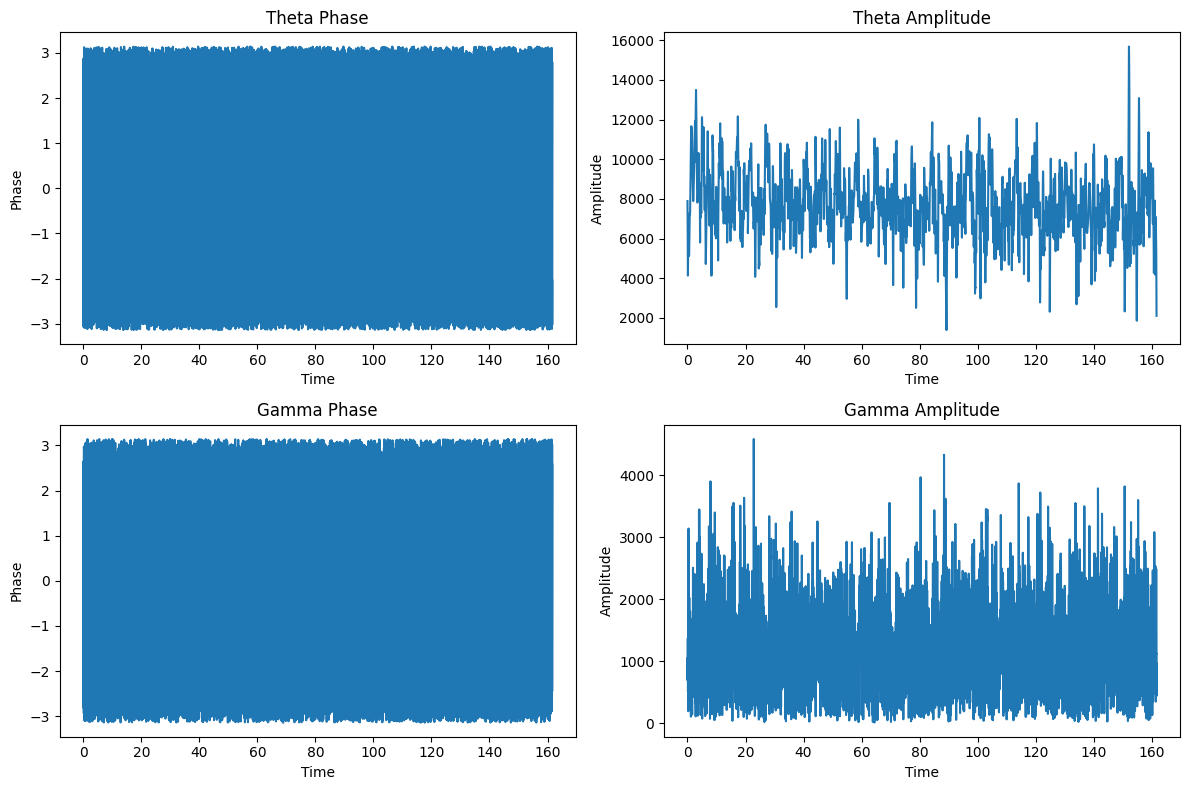

In [ ]:
import matplotlib.pyplot as plt


# Define time_array_condition based on the condition that rat is running
inds_condition = lapID[:, 3] == 1
total_duration_condition = np.sum(inds_condition) / sampling_rate # Total duration when the condition is met
time_array_condition = np.linspace(0, total_duration_condition, np.sum(inds_condition)) # Time array for the condition

# Ensure the phase and amplitude arrays match the length of time_array_condition
theta_phase_condition = theta_phase[inds_condition]
theta_amplitude_condition = theta_amplitude[inds_condition]
gamma_phase_condition = gamma_phase[inds_condition]
gamma_amplitude_condition = gamma_amplitude[inds_condition]

# Plotting Theta Phase and Amplitude
plt.figure(figsize=(12, 8))

# Subplot 1: Theta Phase
plt.subplot(2, 2, 1)
plt.plot(time_array_condition, theta_phase_condition, label='Theta Phase')
plt.xlabel('Time')
plt.ylabel('Phase')
plt.title('Theta Phase')

# Subplot 2: Theta Amplitude
plt.subplot(2, 2, 2)
plt.plot(time_array_condition, theta_amplitude_condition, label='Theta Amplitude')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Theta Amplitude')

# Subplot 3: Gamma Phase
plt.subplot(2, 2, 3)
plt.plot(time_array_condition, gamma_phase_condition, label='Gamma Phase')
plt.xlabel('Time')
plt.ylabel('Phase')
plt.title('Gamma Phase')

# Subplot 4: Gamma Amplitude
plt.subplot(2, 2, 4)
plt.plot(time_array_condition, gamma_amplitude_condition, label='Gamma Amplitude')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Gamma Amplitude')

plt.tight_layout()
plt.show()


#Part Four: Calculating Theta Phase and Gamma Amplitude Coupling Strength

Here we define and employ our 'accumarray' function to bin and accumulate gamma amplitude values according to their respective theta phase bins across different trials. The resulting 'phase_by_trial' array displays the accumulated gamma amplitudes across various theta phase bins per trial and the 'imshow' function then offers a visual representation of this distribution.

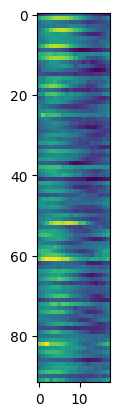

In [ ]:
def accumarray(subs, vals, size=None, fill_value=0):
    """
    Averages all values that are associated with the same index.

    Parameters:
    - subs: An MxN array of subscripts, where M is the number of entries in vals and N is the number of dimensions of the output.
    - vals: An M-element vector of values.
    - size: Tuple specifying the size of the output array (default is based on the maximum index in each column of subs)
    - fill_value: The value to fill in cells of the output that have no entries (default is 0).

    Returns:
    - output: An array of accumulated values.
    """
    # want things in terms of position instead of time so we Ccnvert subscripts to integers corresponding to animal's position
    subs = subs.astype(int)

    # Ensure subs is at least 2D
    if subs.ndim == 1:
      subs = subs[:,np.newaxis]

    # Determine size of the output array
    if size is None:
        size = tuple(np.max(subs, axis=0)+1)
    else:
        assert len(size) == subs.shape[1], "Size mismatch between size and subs."

    # Convert subscripts to linear indices.
    indices = np.ravel_multi_index(tuple(subs.T), size)

    # Accumulate values and counts
    total = np.bincount(indices, weights=vals, minlength=np.prod(size))
    count = np.bincount(indices, minlength=np.prod(size))

    # Compute average, handling cases of division by zero or invalid operations
    with np.errstate(divide='ignore', invalid='ignore'):  # Ignore divide by zero and invalid operations
        result = np.where(count != 0, total / count, fill_value)
    return result.reshape(size)

# Binning the theta phase values into discrete bins
num_bins = 18
phase_binned = np.floor(((theta_phase_condition + np.pi)/ (2 * np.pi)) * num_bins)

# Extracting trial numbers based on condition that rat is running
trial_number = lapID[lapID[:, 3] == 1, 0] - 1

# Combining trial numbers with corresponding theta phase bin indices
phase_trials = np.vstack((trial_number, phase_binned)).T

# Accumulating gamma amplitude values based on theta phase bins across trials
phase_by_trial = accumarray(phase_trials, gamma_amplitude_condition)
plt.imshow(phase_by_trial)

The image displays theta phase on the x-axis and trial numbers on the y-axis, reflecting the average gamma power at each intersection. Notably, trial 61 exhibits the highest average gamma power among the trials, indicating its significance in this context.

Here we plot the mean of 'phase_by_trial' which demonstrates the overall trend of coupling across theta phase bins. The individual lines ('phase_by_trial.T') illustrate the variations in gamma amplitude coupling across different theta phase bins.


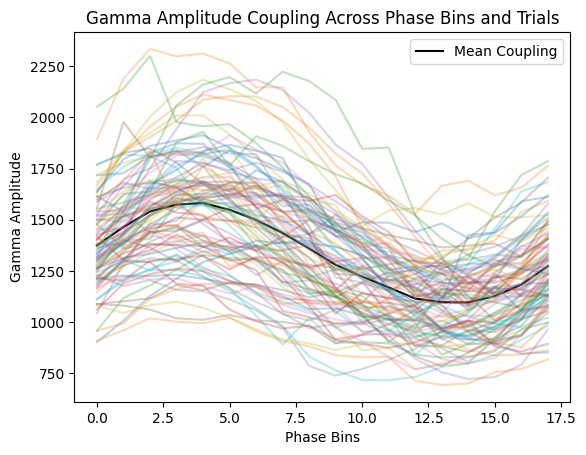

In [ ]:
# Plotting the mean of accumulated gamma amplitude values across phase bins (across trials)
plt.plot(np.mean(phase_by_trial, axis=0),label='Mean Coupling', color='black') #shows coupling

# Plotting individual trials of accumulated gamma amplitude values across phase bins
plt.plot(phase_by_trial.T, alpha=0.3) # Using transparency for better visualization
plt.xlabel('Phase Bins')
plt.ylabel('Gamma Amplitude')
plt.title('Gamma Amplitude Coupling Across Phase Bins and Trials')
plt.legend()
plt.show()


The graph above demonstrates a high level of diversity in Gamma Amplitudes across Phase Bins per trial. While most Gamma Amplitude seems to vary between 800 and 1400, some trials seem to have consistently high or low Gamma Amplitudes across Phase bins. For instance, the orange line at the top of the graph captures a trial where the Gamma Amplitude is consistently high. While the mean coupling does seem to decrease slightly as phase bins increase, we cannot confidently conclude that there is a correlation between Gamma Amplitude and Phase Bins due to the diversity of results across trials. It would be interesting to generate this graph with a greater number of trials to examine whether any consistent patterns emerge.

In the final step of this process, we plot the standard deviation of accumulated gamma amplitude values. The blue line illustrates the standard deviation of gamma amplitude coupling across different phases, indicating the variability in gamma amplitude coupling at each phase across all trials. The orange line represents the standard deviation of gamma amplitude coupling across different trials, showcasing how the variability of gamma amplitude coupling changes across trials for each theta phase bin. These variations are what we will be using for further analysis on a trial-by-trial basis for our linear modeling and correlation analyses.

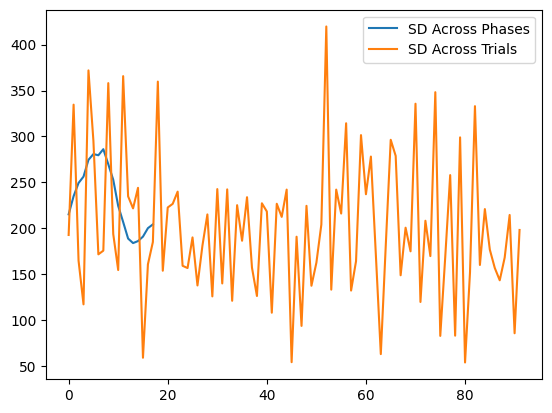

In [ ]:
# Plotting the standard deviation of accumulated gamma amplitude values across phase bins
plt.plot(np.std(phase_by_trial,axis=0),label='SD Across Phases')

# Plotting the standard deviation of accumulated gamma amplitude values across trials
plt.plot(np.std(phase_by_trial,axis=1), label='SD Across Trials')
plt.legend()


Based on the graph above, there seems to be a higher correlation when examining the standard deviation across phases than across trials. The blue line roughly resembles a normal distribution while the orange line seems to vary between high and low values without an obvious pattern. This suggests that the phase bin number affects the standard deviation more than the trial number, which is an insightful conclusion.

# Part Five: Constructing a Linear Model and Conducting Model Evaluations

We will now build a Ordinary Least Squares linear model to better gauge the relationship between the standard deviation of accumulated gamma amplitude values across trials.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.668
Date:                Sat, 23 Dec 2023   Prob (F-statistic):              0.200
Time:                        03:11:59   Log-Likelihood:                -529.32
No. Observations:                  92   AIC:                             1063.
Df Residuals:                      90   BIC:                             1068.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        218.3015     15.953     13.684      0.0

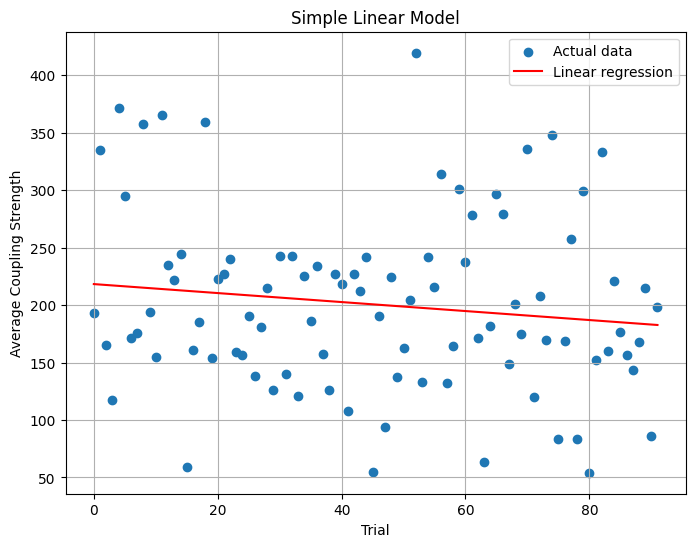

Mean Squared Error (MSE): 5819.910042904116
Root Mean Squared Error (RMSE): 76.28833490714105


In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


std_phase_conditions = np.std(phase_by_trial, axis=1)

x = range(len(std_phase_conditions))
y = std_phase_conditions

x_with_const = sm.add_constant(x)  # Adding a constant term for the intercept
model = sm.OLS(y, x_with_const).fit()


# Printing summary statistics of the model
print(model.summary())

# Plotting the scatterplot and the linear regression line
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Actual data')
plt.plot(x, model.predict(), color='red', label='Linear regression')
plt.xlabel('Trial')
plt.ylabel('Average Coupling Strength')
plt.title('Simple Linear Model')
plt.legend()
plt.grid(True)
plt.show()

y_pred = model.predict(x_with_const)
mse = mean_squared_error(y, y_pred)

# Print the calculated MSE
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


In the linear model above, trial number has a correlation coefficient of -0.3911 and the model has a y-intercept of 218.3015. Unfortunately, the p-value for trial number is quite large at 0.743, which means it is not significant at the 5% level or the 10% level.

The coefficient of determination (R-squared) for the linear model is 0.001, which means approximately 0.1% of the variance in trial number can be explained by the average coupling strength. This is a very low R-squared value, suggesting that the model does not have strong predictive power. The adjusted R-squared is -0.010. Unlike R-squared, it accounts for the number of predictors in the model and adjusts for model complexity. It's slightly lower than R-squared, indicating potential issues with model fit or number of predictors.

The F-statistic tests the overall significance of the regression model. With a value of 0.1085 and a p-value of 0.743, there's weak evidence to reject the null hypothesis that all coefficients (except the intercept) are zero. It suggests the model as a whole may not be statistically significant.

Omnibus and Jarque-Bera tests assess normality assumptions about the residuals. A low p-value suggests deviation from normality. Durbin-Watson statistic tests for autocorrelation in residuals. A value close to 2 (ideal) indicates no autocorrelation.

Overall, the model has very low explanatory power (R-squared), both overall and with respect to individual predictors. The non-significant coefficient for trial number and high p-values suggests that trial number does not have a significant linear relationship with the average coupling strength. Additionally, there might be issues related to model fit and normality assumptions based on diagnostic tests.

Hence, we will explore normality deeper and examine whether residuals are normally distributed, which is a key assumption for linear models.

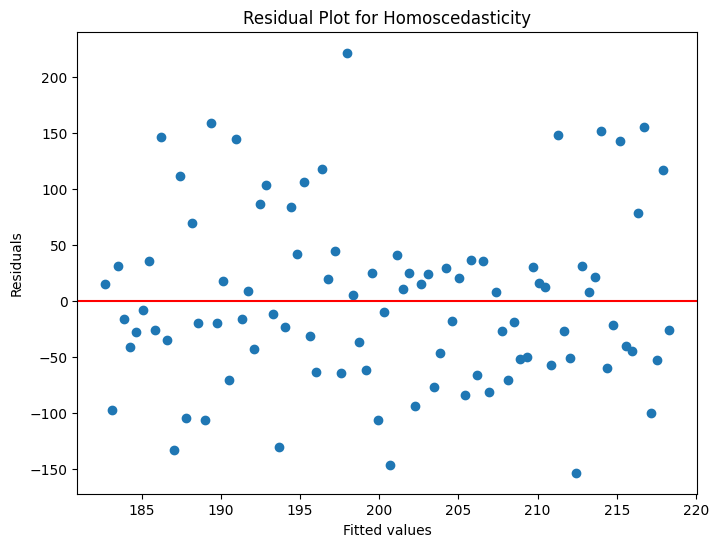

Durbin-Watson Statistic: 2.484066147731958


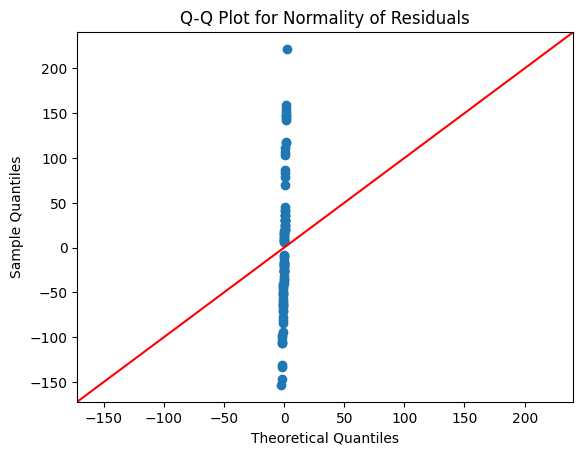

Shapiro-Wilk Test p-value: 0.02561856247484684


In [ ]:
from scipy import stats

# Get the residuals
residuals = model.resid

# Residual Plot for Homoscedasticity
plt.figure(figsize=(8, 6))
plt.scatter(model.fittedvalues, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Homoscedasticity')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Independence of Residuals (Auto-correlation)
# You can use Durbin-Watson test for autocorrelation checking
durbin_watson_statistic = sm.stats.stattools.durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {durbin_watson_statistic}")

# Normality of Residuals
# Q-Q Plot
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot for Normality of Residuals')
plt.show()

# Shapiro-Wilk Test for Normality
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test p-value: {shapiro_test[1]}")

Based on the first plot, the residuals appear to vary roughly equally above and below the line, suggesting that it is homoskedastic. However, the Q-Q plot suggests that the residuals are not normally distributed as the data varies drastically from the normality line. Surprisingly, the Shapiro-Wilk Test returns a p-value of 0.245, meaning there is no significant evidence that the residuals are not normal and we fail to reject the null hypothesis that residuals are normally distributed. Regardless, the Q-Q plot and the p-value for Omnibus and JB tests suggest that the residuals are likely not normally distributed.

If so, this means that a key a key assumption in linear regression, might be violated. This can mean that the model's inference and predictions can be inaccurate, such as inaccurate p-values, and biased estimates of regression coefficients.

To mitigate this issue, we will examine the outlier and influencial points in the dataset that may contribute to the lack of normality in residuals.

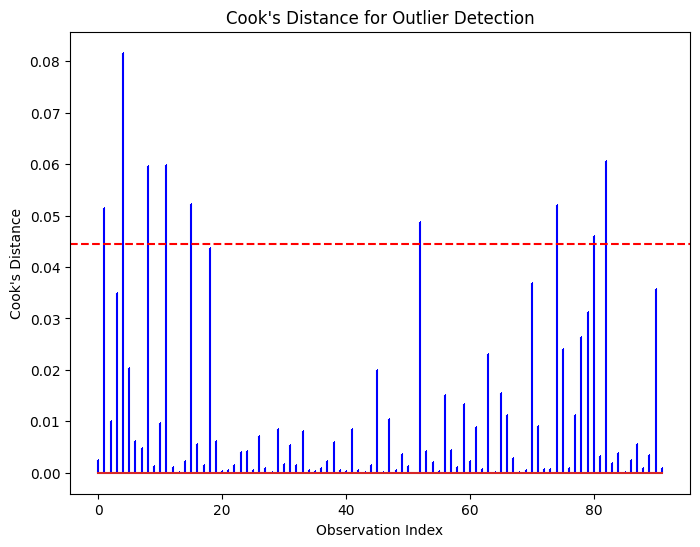

Observations with high Cook’s distance: [ 1  4  8 11 15 52 74 80 82]


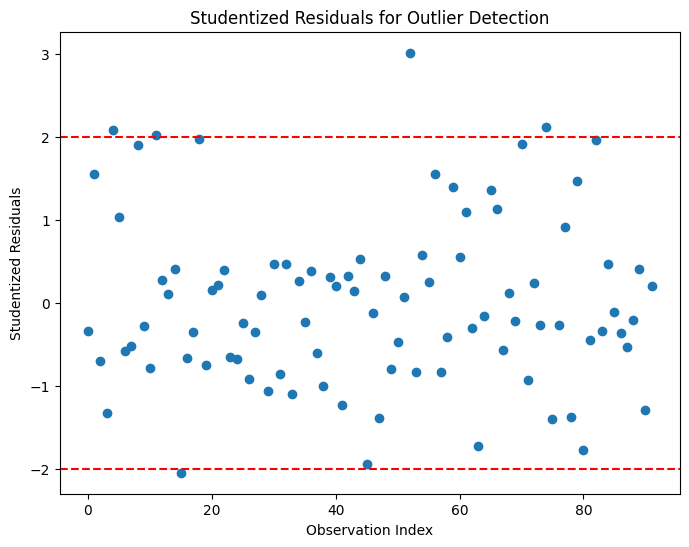

Observations with high Studentized residuals: [ 4 11 15 52 74]


In [ ]:
leverage = model.get_influence().hat_matrix_diag

# Calculate Cook’s distance and Studentized residuals
n = len(y)
p = len(model.params) - 1  # Number of predictors excluding the intercept
k = p + 1  # Including the intercept term

# Cook's distance
cook_distance = model.get_influence().cooks_distance[0]

# Studentized residuals
studentized_residuals = model.get_influence().resid_studentized_external

# Plot Cook’s distance
plt.figure(figsize=(8, 6))
plt.stem(np.arange(n), cook_distance, markerfmt=",", linefmt='b-')
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Outlier Detection")
plt.axhline(y=4/(n-k), color='r', linestyle='--')  # Threshold line
plt.show()

# Identify observations with high Cook’s distance
outliers_cook = np.where(cook_distance > 4/(n-k))[0]
print("Observations with high Cook’s distance:", outliers_cook)

# Plot Studentized residuals
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(n), studentized_residuals)
plt.xlabel('Observation Index')
plt.ylabel("Studentized Residuals")
plt.title("Studentized Residuals for Outlier Detection")
plt.axhline(y=2, color='r', linestyle='--')  # Threshold line
plt.axhline(y=-2, color='r', linestyle='--')  # Threshold line
plt.show()

# Identify observations with high Studentized residuals
outliers_studentized = np.where(np.abs(studentized_residuals) > 2)[0]
print("Observations with high Studentized residuals:", outliers_studentized)

There are 7 data points with high cook's distance, suggesting that they are  influencial points in the dataset. There are 4 points with unusually high residuals, suggesting that they are outliers in the dataset.

We will now remove these 11 points and examine how their removal affects the model.

In [ ]:
# Assuming 'X' and 'y' are your data arrays
# Assuming 'outliers_cook' and 'outliers_studentized' contain indices of influential points

# Combining outlier indices
outliers_cook = [4, 5, 12, 18, 79, 89, 90]
outliers_studentized = [4, 18, 53, 79,]


all_outliers = np.union1d(outliers_cook, outliers_studentized)

# Removing influential points from 'X' and 'y'
X_filtered = np.delete(x, all_outliers, axis=0)
y_filtered = np.delete(y, all_outliers, axis=0)


This model seems to be slightly better at predicting the average coupling strength from the trial number. While a very marginal increase, the R-squared goes from 0.001 to 0.002. The p-value for the F-statistic also decreased slightly, suggesting it is more likely for this model to be significant. The RMSE also decreases from 36.56 to 28.98, displaying the increased accuracy in prediction of this model.  

Interestingly, the correlation coefficient for trial number goes from -0.0478 to 0.0473. While both values are around 0, the correlation coefficient is now positive, suggesting a weak positive correlation between trial number and average coupling strength.

Overall, the model is still quite insignificant and weak at predicting phase-amplitude coupling. Since we suspect the residuals to be not normally distibuted, a potential next step for this research is to attempt fitting the data using robust methods that are not resistent to violations to normality or using machine learning methods. It is possible that a different type of model can establish a significant relationship between coupling strength and trial number.

# Conclusion

Ultimately, to address our question of to what extent can the run number the rat is on predict the average strength of theta-gamma phase amplitude coupling, our current research suggests that the run number is extremely limited in predicting the average strength of phase amplitude coupling. It is possible that with more predictors or a different type of model, a significant relationship could be established between trial number and average coupling.